# Import Packages #

In [ ]:
#Installing necessary tools
#&> /dev/null ensures that there is no readout

!pip install transformers &> /dev/null
!pip install nlpaug &> /dev/null
!pip install bert-tensorflow &> /dev/null
!pip install torch &> /dev/null
!pip install ipywidgets &> /dev/null
!pip install torch &> /dev/null



In [ ]:
import random
import pandas as pd
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download("stopwords")

import matplotlib.pyplot as plt
#renders the figure inline (figure displayed directly below the cell)
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go

from tqdm.auto import tqdm
from sklearn.utils import shuffle
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import SGDClassifier
from tensorflow.keras import layers

#### Binary Text Classification (supervised learning) ####

### preparing and labeling data ###

#importing libraries
from keras.preprocessing.text import Tokenizer
from keras import preprocessing
from keras.preprocessing.text import text_to_word_sequence
import random
from tensorflow import keras
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import nlpaug.augmenter.word.context_word_embs as aug
from tqdm.auto import tqdm
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import transformers

from transformers import AutoModel, BertTokenizerFast
from tqdm import tqdm
from ipywidgets import IntProgress
import nlpaug.augmenter.word as naw
from sklearn.feature_extraction.text import CountVectorizer

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')
from collections import Counter


#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#renders the figure inline (figure displayed directly below the cell)
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go
import joblib


#BERT#
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from ipywidgets import IntProgress
from sklearn.decomposition import PCA

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from transformers import AdamW


import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Uploading data ###

In [ ]:
#Establishing a drive connection
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data exploration #

## Import and format data ##

In [ ]:
## Reading in the data and creating a new dataframe from which I can perform EDA

#Uploading the csv file and inspecting the first 10 rows
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/amlh_coursework_2023_annotated.csv')
df.head(10)

,file,start,end,text,class
0,3241_General Medicine.txt,1820,1828,cyanosis,Phenotypes
1,3241_General Medicine.txt,1327,1344,umbilical hernias,Phenotypes
2,3241_General Medicine.txt,1356,1363,ascites,Phenotypes
3,3241_General Medicine.txt,1842,1847,edema,Phenotypes
4,3241_General Medicine.txt,1526,1534,prostate,Body_parts
5,3241_General Medicine.txt,1596,1607,lymph nodes,Body_parts
6,3241_General Medicine.txt,121,125,SKIN,Body_parts
7,3241_General Medicine.txt,199,204,HEENT,Body_parts
8,3241_General Medicine.txt,1654,1658,neck,Body_parts
9,3241_General Medicine.txt,595,599,NECK,Body_parts


Attribute desctiption


* file - the file name
* start - the annotation start offset (position by characters from the start of the file)
* end - the annotation end offset
* text - the annotated text (as it is in the original document, i.e., doc_str[start:end])
* class - the type of the mention.

In [ ]:
# need to oversample body_parts data (post-test/train split)
df['class'] = df['class'].replace({'Phenotypes': [1], 'Body_parts': [0]})

In [ ]:
#Printing value counts and length of class
print(df['class'].value_counts()/len(df['class']))

1    0.58234
0    0.41766
Name: class, dtype: float64


In [ ]:
#Finding, if any, null values
df.isna().sum()

file     0
start    0
end      0
text     0
class    0
dtype: int64

#Data Pre-processing#

## Define training, validation, and testing sets ##

In [ ]:
#Initating X and Y

text = df['text'] #X
class_label = df['class'] #Y


# set the randome state for reproducing
random_state = 9
test_size = 0.2

#Create train, val, test split
X_train_val, X_test, y_train_val, y_test = train_test_split(text, class_label, test_size=test_size, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.1, random_state=random_state)

 ### Balancing the data with an BERT-based augmenter ###

In [ ]:
#load augmeneter using a pre-train BERT-based-uncased model

augmenter = aug.ContextualWordEmbsAug(model_path= "bert-base-uncased", action='insert')

In [ ]:
#Comparing sample text and augmented text to test similarity

sample_text = df['text'].iloc[1000:1010]
print(sample_text)

print('------------')

aug_sample_text = augmenter.augment(sample_text)
print(aug_sample_text)

1000           lumbar
1001     intracranial
1002          ethmoid
1003         sphenoid
1004         sphenoid
1005     fibrous scar
1006            tumor
1007      scar tissue
1008    complications
1009            tumor
Name: text, dtype: object
------------
['1 lumbar']


In [ ]:
# Defining an function tht will produce an augmented dataframe for each set

def augmentMyData(df, augmenter, repetitions=1, samples=200):
    augmented_texts = []
    # Select only the minority class samples
    body_df = df[df['label'] == 0].reset_index(drop=True)  # Remove unnecessary index column
    for i in np.random.randint(0, len(body_df), samples):
        # Generate 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(body_df['text'].iloc[i])
            augmented_texts.append(augmented_text)

    data = {
        'label': np.zeros(len(augmented_texts), dtype=int),
        'text': augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(pd.concat([df, aug_df]).reset_index(drop=True))
    return df #creating a new augmented dataframe

#augmentation sample size depends on the class counts for each set

In [ ]:
#establishing augmented train dataframe - number of samples refers to the n-difference in classes
augmented_train_df = augmentMyData(pd.DataFrame({'text': X_train, 'label': y_train}),
                                   augmenter=augmenter,
                                   samples=1992)

In [ ]:
#establishing augmented validation dataframe - number of samples refers to the n-difference in classes
augmented_val_df = augmentMyData(pd.DataFrame({'text': X_val, 'label': y_val}),
                                   augmenter=augmenter,
                                   samples=238)

In [ ]:
#saving a copy of the augmented dataframe
augmented_train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/augmented_train_df_final.csv')
augmented_val_df.to_csv('/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/augmented_val_df_final.csv')

In [ ]:
#augmented_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/augmented_train_df_final.csv')
#augmented_val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/augmented_val_df_final.csv')

In [ ]:
# Get the augmented texts and labels
X_train_augmented = augmented_train_df['text']
y_train_augmented = augmented_train_df['label']
X_val_augmented = augmented_val_df['text']
y_val_augmented = augmented_val_df['label']

In [ ]:
#Shuffle the data
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)
X_val_augmented, y_val_augmented = shuffle(X_val_augmented, y_val_augmented)

In [ ]:
#Printing new lengths
print(len(X_train_augmented))
print(len(X_val_augmented))

print(y_train_augmented.value_counts())
print(y_val_augmented.value_counts()) #2344

14010
1574
1    7005
0    7005
Name: label, dtype: int64
0    787
1    787
Name: label, dtype: int64


### Text cleaning ###

In [ ]:
#Defining a function to pre-process text

def pre_process(string):
    # Remove square brackets
    string = re.sub(r'\[|\]', '', string)
    # Remove quotation marks
    string = re.sub(r'\'', '', string)
    # Lower cases in string
    string = string.lower()
    return string

In [ ]:
#Changing the dtype to string to all for text pre-process

X_train_augmented = X_train_augmented.astype('string')
X_val_augmented = X_val_augmented.astype('string')
X_test = X_test.astype('string')

In [ ]:
#applying the pre-process to train, val, and test sets

X_train_augmented = X_train_augmented.apply(lambda x: pre_process(x))
X_val_augmented = X_val_augmented.apply(lambda x: pre_process(x))
X_test = X_test.apply(lambda x: pre_process(x))

In [ ]:
#Turning sets into lists to be further processed

X_train_augmented_list = X_train_augmented.tolist()
y_train_augmented_list = y_train_augmented.tolist()
X_val_augmented_list = X_val_augmented.tolist()
y_val_augmented_list = y_val_augmented.tolist()
X_test_list = X_test.tolist()
y_test_list = y_test.tolist()

In [ ]:
#confirmation that sets properly pre-processed and are lists
print(X_train_augmented_list[1:10])
print(X_val_augmented_list[1:10])
print(X_test_list[1:10])

['left lower quadrant', 'icterus', '... lungs', 'in cardiovascular', 'lungs', 'discharge', 'purulent sputum', 'base', 'patellar']
['allergic symptoms', 'site', 'giant gallbladder', 'pneumonia', 'site', 'gallstone', 'rigidity', 'chills', 'epigastric']
['mesentery', 'acute abdominal pain', 'coronary artery', 'coughing', 'vertebral', 'rash', 'cranial nerves', 'pneumonia', 'apraxia']


# Method 1: Random Forest Classification #

In [ ]:
## Establishing Tokenizer ##

tokenizer = Tokenizer()
tfidf_vectorizer = TfidfVectorizer()
tokenizer.fit_on_texts(X_train_augmented_list)
num_unique_tokens = len(tokenizer.word_index)

In [ ]:
# Tokenize, pad, and convert to TF-IDF matrix for X_train_augmented_list
X_train_sequences = tokenizer.texts_to_sequences(X_train_augmented_list)
max_sequence_length_train = max([len(seq) for seq in X_train_sequences])

# Tokenize, pad, and convert to TF-IDF matrix for X_val_augmented_list
X_val_sequences = tokenizer.texts_to_sequences(X_val_augmented_list)

# Tokenize, pad, and convert to TF-IDF matrix for X_test_list
X_test_sequences = tokenizer.texts_to_sequences(X_test_list)

# Apply the same padding to all sequences
X_train_padded_sequences = pad_sequences(X_train_sequences, maxlen=max_sequence_length_train)
X_val_padded_sequences = pad_sequences(X_val_sequences, maxlen=max_sequence_length_train)
X_test_padded_sequences = pad_sequences(X_test_sequences, maxlen=max_sequence_length_train)

# Convert sequences to strings for TF-IDF vectorization
X_train_sequences_strings = [' '.join(map(str, sequence)) for sequence in X_train_padded_sequences]
X_val_sequences_strings = [' '.join(map(str, sequence)) for sequence in X_val_padded_sequences]
X_test_sequences_strings = [' '.join(map(str, sequence)) for sequence in X_test_padded_sequences]

# Fit the TF-IDF vectorizer on X_train_sequences_strings and transform all datasets
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train_sequences_strings)
X_val_tfidf_matrix = tfidf_vectorizer.transform(X_val_sequences_strings)
X_test_tfidf_matrix = tfidf_vectorizer.transform(X_test_sequences_strings)

# Convert TF-IDF matrices to arrays
X_train_tfidf_array = X_train_tfidf_matrix.toarray()
X_val_tfidf_array = X_val_tfidf_matrix.toarray()
X_test_tfidf_array = X_test_tfidf_matrix.toarray()

In [ ]:
# Convert label (y) matrices to arrays
y_train_augmented = np.array(y_train_augmented)
y_val_augmented = np.array(y_val_augmented)
y_test = np.array(y_test)

In [ ]:
# Print shapes of arrays
print(X_train_tfidf_array.shape)
print(y_train_augmented.shape)
print(X_val_tfidf_array.shape)
print(y_val_augmented.shape)
print(X_test_tfidf_array.shape)
print(y_test.shape)


(14010, 2575)
(14010,)
(1574, 2575)
(1574,)
(3339, 2575)
(3339,)


### Tfidf-Vector Representation ###

In [ ]:
# Compute TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(X_train_augmented_list)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class_labels = y_train_augmented_list

# Create t-SNE model with 2 components (2D visualization)
tsne_model = TSNE(n_components=2, random_state=42)

# Apply t-SNE to TF-IDF vectors
tsne_data = tsne_model.fit_transform(tfidf_vectors.toarray())


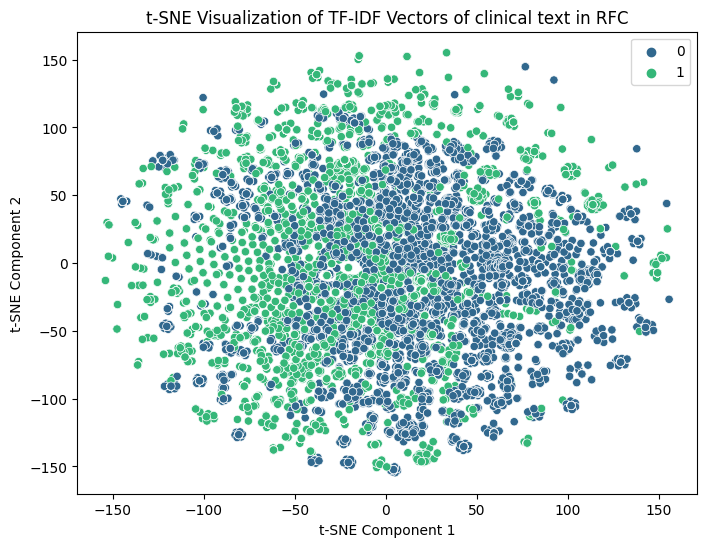

In [ ]:
# Create a scatter plot for visualization

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=class_labels, marker='o', palette='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of TF-IDF Vectors of clinical text in RFC')
plt.show()

In [ ]:
# Define the model
class RandomForest_Text_Classifier:

    def __init__(self, n_estimators=100, max_depth=None, random_state=None):

        self.rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Define the training method
    def train(self, X_train, y_train):
        self.rfc.fit(X_train, y_train)

    # Define the prediction method
    def predict(self, X_test):
        return self.rfc.predict(X_test)

In [ ]:
rfc = RandomForestClassifier(random_state=42)

In [ ]:
rfc.fit(X_train_tfidf_array, y_train_augmented)

RandomForestClassifier(random_state=42)

In [ ]:
#saving rfc model
joblib.dump(rfc, "/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/rfc_model.joblib")

['/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/rfc_model.joblib']

In [ ]:
rfc = joblib.load("/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/rfc_model.joblib")

In [ ]:
## performing metrics on X_train_scaled

#predicting severity score based off training values
y_pred_train_rfc = rfc.predict(X_train_tfidf_array)

#classification report using y_train vs. y__train_predicted
print('Classification report for training set (k_rfc)')
print(classification_report(y_train_augmented, y_pred_train_rfc))

#printing the roc_auc score for the training set
print("Train ROC score:",roc_auc_score(y_pred_train_rfc, y_train_augmented))

score_rfc_train = rfc.score(X_train_tfidf_array, y_train_augmented)
print(f"R^2(coefficient of determination) on training set = {round(score_rfc_train, 3)}")

Classification report for training set (k_rfc)
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7005
           1       0.99      0.96      0.97      7005

    accuracy                           0.97     14010
   macro avg       0.97      0.97      0.97     14010
weighted avg       0.97      0.97      0.97     14010

Train ROC score: 0.9748627094669708
R^2(coefficient of determination) on training set = 0.975


In [ ]:
## performing metrics on X_test_scaled

#predicting severity score based off training values
y_pred_test_rfc = rfc.predict(X_test_tfidf_array)


#classification report using y_test vs. y__test_predicted
print('Classification report for test set (k_rfc)')
print(classification_report(y_test, y_pred_test_rfc))

#printing the roc_auc score for the test set
print("Test ROC score:",roc_auc_score(y_pred_test_rfc, y_test))

score_rfc_test = rfc.score(X_test_tfidf_array, y_test)
print(f"R^2(coefficient of determination) on test set = {round(score_rfc_test, 3)}")

Classification report for test set (k_rfc)
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1410
           1       0.99      0.90      0.94      1929

    accuracy                           0.94      3339
   macro avg       0.93      0.94      0.94      3339
weighted avg       0.94      0.94      0.94      3339

Test ROC score: 0.9343329752211319
R^2(coefficient of determination) on test set = 0.937


Text(0.5, 0.98, 'RFC Confusion Matrix')

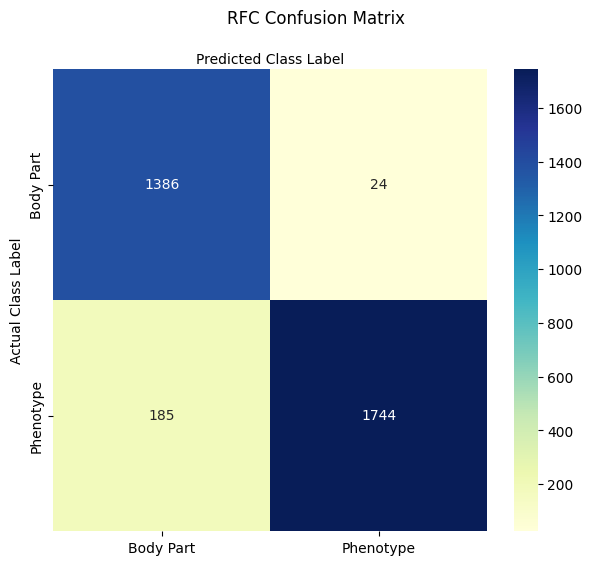

In [ ]:
##heatmap showing the confusion matrix for true positives (TP), true negtaives (TN), false positives (FP), and false negatives (FN)

#specifing plot parameters
class_names = ['Body Part', 'Phenotype'] # name of classes
title = 'RFC Confusion Matrix'
ylabel = 'Actual Class Label'
xlabel = 'Predicted Class Label'
tick_marks = [0.5, 1.5]
data = pd.DataFrame(confusion_matrix(y_test, y_pred_test_rfc))
figsize = (7,6)

#plot figure
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data, annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.suptitle(title)

Text(0.5, 1.0, 'AUC ROC from Predictions (rfc)')

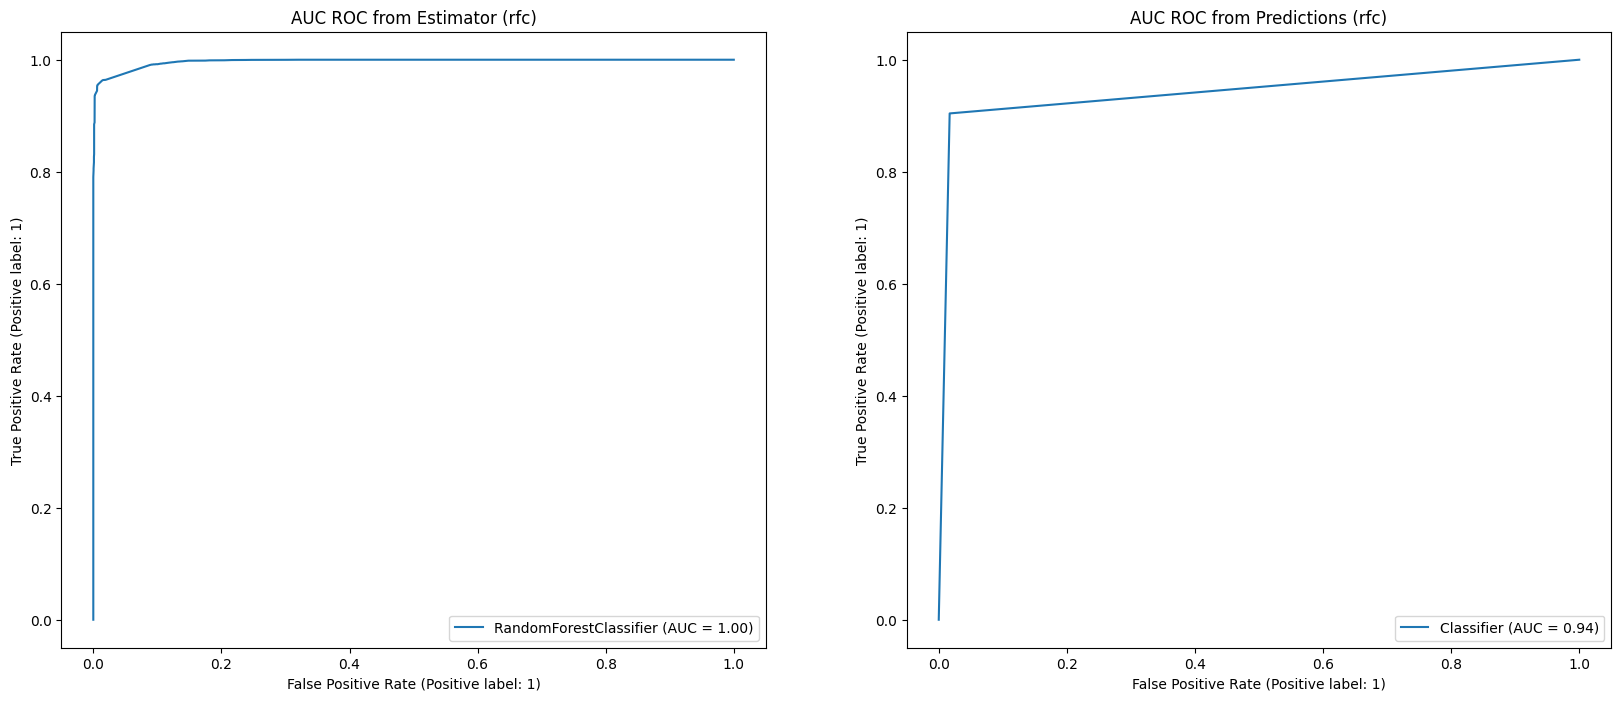

In [ ]:
#displaying roc_auc for test data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

#'from_estimator' plots the ROC curve on the model that has already been fit to data
RocCurveDisplay.from_estimator(rfc, X_train_tfidf_array, y_train_augmented, ax = ax1)
ax1.set_title('AUC ROC from Estimator (rfc)')
#'from_predictor' plots the ROC curve using predicted scores or probabilities and the true binary labels
RocCurveDisplay.from_predictions(y_test, y_pred_test_rfc, ax = ax2)
ax2.set_title('AUC ROC from Predictions (rfc)')

In [ ]:
# Define the hyperparameter grid for the RFC
n_estimators = [100, 150, 300]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num=12)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': [True, False],
    'criterion': criterion
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rfc,param_distributions = random_grid,
               n_iter = 50, cv = 10, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_val_tfidf_array, y_val_augmented)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 300]},
                   random_state=42, verbose=2)

In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')
print('Best estimator: ', rf_random.best_estimator_, ' \n')

Random grid:  {'n_estimators': [100, 150, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']} 

Best Parameters:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'criterion': 'entropy', 'bootstrap': True}  

Best estimator:  RandomForestClassifier(criterion='entropy', max_depth=110, max_features='auto',
                       n_estimators=150, random_state=42)  



In [ ]:
X_train_bp = np.concatenate((X_train_tfidf_array, X_val_tfidf_array))
y_train_bp = np.concatenate((y_train_augmented, y_val_augmented))

In [ ]:
rfc_bp = rf_random.best_estimator_
rfc_bp.fit(X_train_bp, y_train_bp)

RandomForestClassifier(criterion='entropy', max_depth=110, max_features='auto',
                       n_estimators=150, random_state=42)

In [ ]:
#saving model
joblib.dump(rfc_bp, "/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/rfc_bp_model.joblib")

['/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/rfc_bp_model.joblib']

In [ ]:
rfc_train_bp = joblib.load("/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/rfc_bp_model.joblib")

In [ ]:
## performing metrics on X_train with best parameters

#predicting severity score based off training values
y_pred_train_rfc_bp = rfc_bp.predict(X_train_bp)

#classification report using y_train vs. y_train_predicted
print('Classification report for training set (k_rfc)')
print(classification_report(y_train_bp, y_pred_train_rfc_bp))

#printing the roc_auc score for the training set
print("Train ROC score:",roc_auc_score(y_pred_train_rfc_bp, y_train_bp))

score_rfc_train_bp = rfc.score(X_train_bp, y_train_bp)
print(f"R^2(coefficient of determination) on training set = {round(score_rfc_train_bp, 3)}")

Classification report for training set (k_rfc)
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      7792
           1       0.76      0.99      0.86      7792

    accuracy                           0.84     15584
   macro avg       0.87      0.84      0.84     15584
weighted avg       0.87      0.84      0.84     15584

Train ROC score: 0.8743455757260732
R^2(coefficient of determination) on training set = 0.971


In [ ]:
## performing metrics on X_test_scaled with best parameter

#predicting severity score based off training values
y_pred_test_rfc_bp = rfc_bp.predict(X_test_tfidf_array)

#classification report using y_test vs. y_test_predicted
print('Classification report for test set (k_rfc)')
print(classification_report(y_test, y_pred_test_rfc_bp))

#printing the roc_auc score for the test set
print("Test ROC score:",roc_auc_score(y_pred_test_rfc_bp, y_test))

score_rfc_test_bp = rfc.score(X_test_tfidf_array, y_test)
print(f"R^2(coefficient of determination) on test set = {round(score_rfc_test_bp, 3)}")

Classification report for test set (k_rfc)
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      1410
           1       0.80      0.98      0.88      1929

    accuracy                           0.84      3339
   macro avg       0.88      0.82      0.83      3339
weighted avg       0.86      0.84      0.84      3339

Test ROC score: 0.8758588468092123
R^2(coefficient of determination) on test set = 0.937


Text(0.5, 0.98, 'RFC_BP Confusion Matrix')

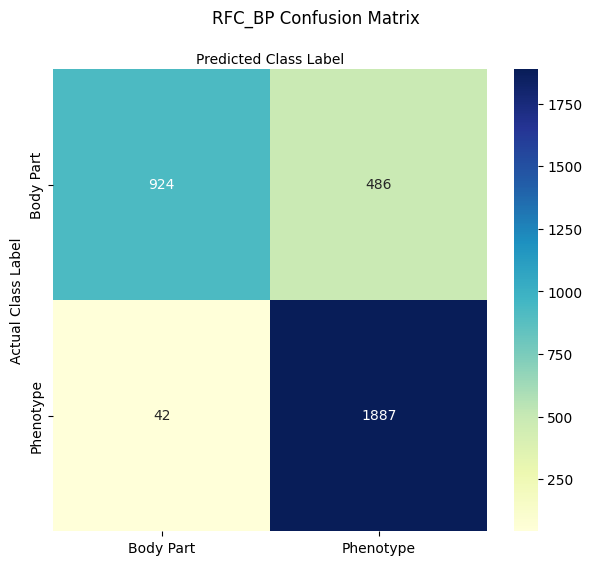

In [ ]:
### Figure 5
##heatmap showing the confusion matrix for true positives (TP), true negtaives (TN), false positives (FP), and false negatives (FN)

#specifing plot parameters
class_names = ['Body Part', 'Phenotype'] # name of classes
title = 'RFC_BP Confusion Matrix'
ylabel = 'Actual Class Label'
xlabel = 'Predicted Class Label'
tick_marks = [0.5, 1.5]
data = pd.DataFrame(confusion_matrix(y_test, y_pred_test_rfc_bp))
figsize = (7,6)

#plot figure
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(data, annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.suptitle(title)

Text(0.5, 1.0, 'AUC ROC from Predictions (rfc_bp)')

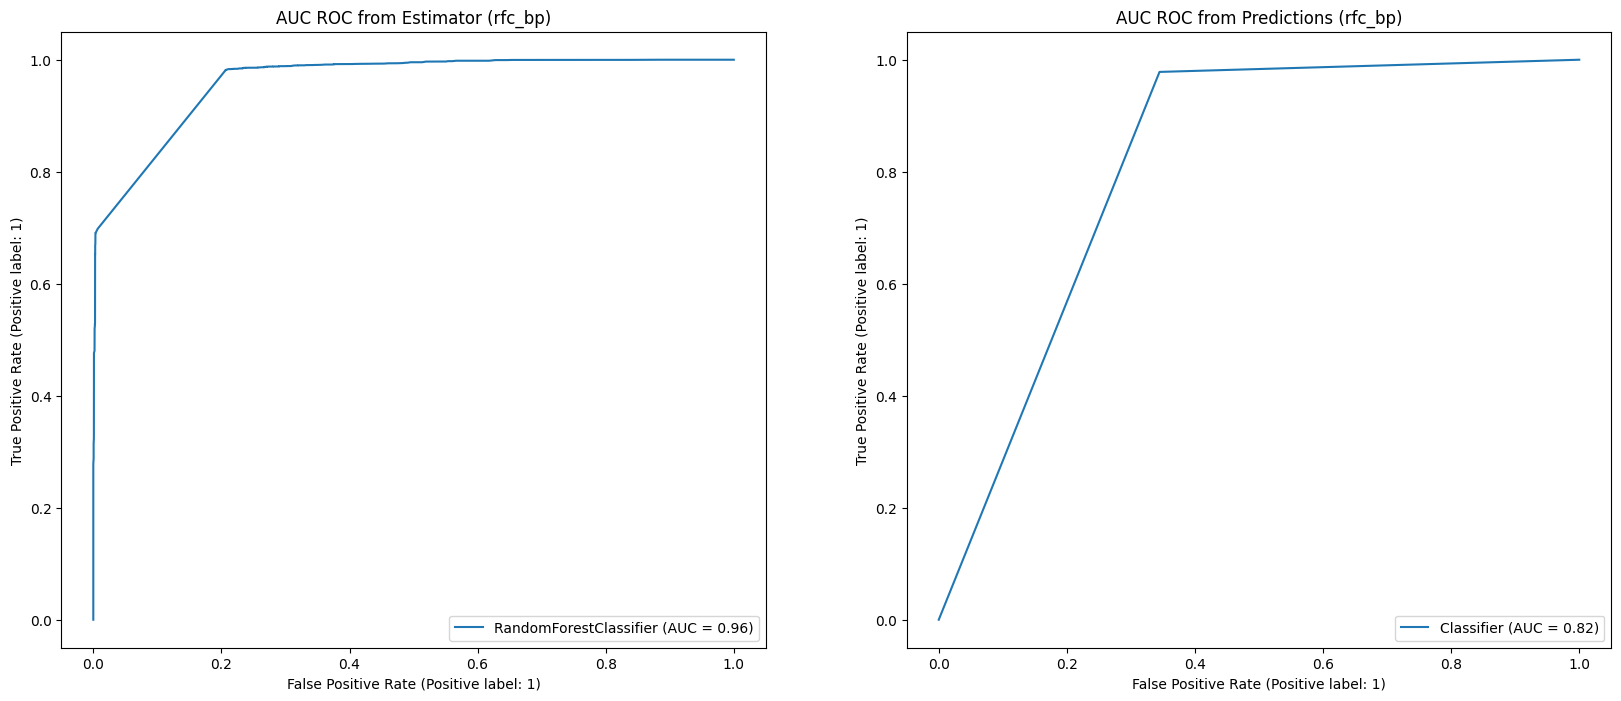

In [ ]:
#displaying roc_auc for test data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

#'from_estimator' plots the ROC curve on the model that has already been fit to data
RocCurveDisplay.from_estimator(rfc_bp, X_train_bp, y_train_bp, ax = ax1)
ax1.set_title('AUC ROC from Estimator (rfc_bp)')
#'from_predictor' plots the ROC curve using predicted scores or probabilities and the true binary labels
RocCurveDisplay.from_predictions(y_test, y_pred_test_rfc_bp, ax = ax2)
ax2.set_title('AUC ROC from Predictions (rfc_bp)')

### **BERT**

In [ ]:
!pip install transformers &> /dev/null
!pip install torch &> /dev/null

In [ ]:
#define a batch size
batch_size = 64
epochs = 20
learning_rate = 3e-5

In [ ]:
from ipywidgets import IntProgress

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
BERT_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
import torch
from torch.utils.data import TensorDataset

def prepare_X_y(texts, labels):
    tokenized = BERT_tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y, tokenized

train_seq, train_mask, train_y, train_tokenized = prepare_X_y(X_train_augmented_list, y_train_augmented_list)
val_seq, val_mask, val_y, val_tokenized = prepare_X_y(X_val_augmented_list, y_val_augmented_list)
test_seq, test_mask, test_y, test_tokenized = prepare_X_y(X_test_list, y_test_list)

## PCA Visualization ##

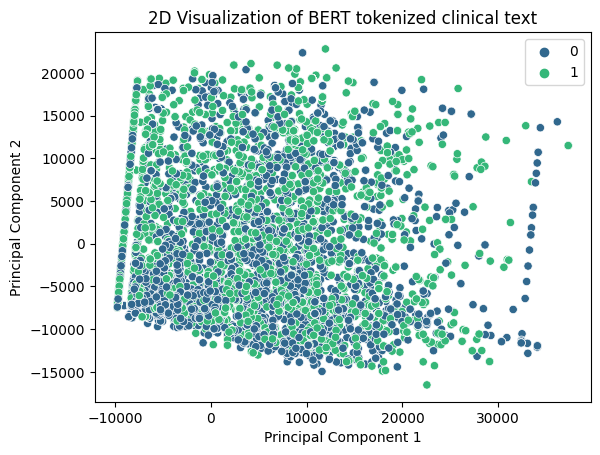

In [ ]:
from sklearn.decomposition import PCA

# Extract the input IDs from the BatchEncoding object
input_ids = train_tokenized["input_ids"]
labels = train_y

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(input_ids)

# Flatten the input_ids to use as the 'hue' parameter in scatterplot

# Create the scatter plot using Seaborn
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="viridis")
plt.title("2D Visualization of BERT tokenized clinical text")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## Defining training, validation, sets ##

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
validation_data = TensorDataset(val_seq, val_mask, val_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# samplers for sampling the data during training, validation and testing
sampler = RandomSampler(training_data)
val_sampler = RandomSampler(validation_data)
test_sampler = RandomSampler(test_data)

# dataLoader for train, validation and test sets
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
validation_data_loader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size)
test_data_loader = DataLoader(test_data, sampler=test_sampler)

In [ ]:
# Define the model

class BERT_Text_Classifier(nn.Module):

    def __init__(self, bert, class_num, bert_dim=768, hidden_dim=512):

        super(BERT_Text_Classifier, self).__init__()

        self.bert = bert

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(bert_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, class_num),
            nn.LogSoftmax(dim=1)
        )

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert(seq, attention_mask=mask)

        lhs = bert_out['pooler_output']
        return self.linear_relu_stack(lhs)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate(m, eval_data_loader, eval_labels=[1], device='cuda'):
    y_true = []
    y_pred = []
    m.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in tqdm(eval_data_loader):
            X_batch, mask, y_batch = batch
            X_batch, mask, y_batch = X_batch.to(device), mask.to(device), y_batch.to(device)
            preds = m(X_batch, mask)
            predicted = torch.argmax(preds, dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, labels=eval_labels)
    cm = confusion_matrix(y_true, y_pred)
    return {"data": (y_true, y_pred),
            "performance": {
                "precision": p[0],
                "recall": r[0],
                "f1": f[0]},
            "confusion_matrix": cm}

def evaluate_mul(m, td_loader, eval_labels=[1], k=30):
    rets = [evaluate(m, td_loader, eval_labels=eval_labels) for _ in range(k)]
    return pd.DataFrame([(ret['performance']['precision'], ret['performance']['recall'], ret['performance']['f1']) for ret in rets],
                        columns=['precision', 'recall', 'f1'])

In [ ]:
#setting the device to cpu, if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from transformers import AdamW

# initialise the model use pretrained bert instance and the label numbers
bert = bert.to(device)
model = BERT_Text_Classifier(bert, class_num=len(class_label))

# push the model to GPU
model = model.to(device)

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = learning_rate)

cross_entropy  = nn.NLLLoss()

In [ ]:
import torch
import copy
import matplotlib.pyplot as plt

def train_model(model, training_data_loader, optimizer, cross_entropy, device='cuda'):
    model.train()  # Set the model to training mode

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for step, batch in enumerate(training_data_loader):
        # Use GPU if available
        seq, mask, labels = batch
        seq, mask, labels = seq.to(device), mask.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Get model outputs
        outputs = model(seq, mask)

        # Compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Calculate the number of correct predictions for accuracy calculation
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

        # Calculate the gradients
        loss.backward()

        # Deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

    # Calculate average loss and accuracy
    average_loss = total_loss / len(training_data_loader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy

def epoch_loop(model, training_data_loader, validation_data_loader, epochs, optimizer, cross_entropy, device='cuda'):
    best_model_state = None
    best_score = -1

    # Lists to store training and validation accuracies and losses per epoch
    train_accuracies = []
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        # Train the model and get average loss and accuracy
        average_loss, accuracy = train_model(model, training_data_loader, optimizer, cross_entropy, device=device)

        # Evaluate model performance on the validation set
        ret = evaluate(model, validation_data_loader, device=device)
        val_accuracy = ret['performance']['f1']

        # Store training and validation accuracies and losses
        train_accuracies.append(accuracy)
        train_losses.append(average_loss)
        val_accuracies.append(val_accuracy)

        if best_score < val_accuracy:
            best_score = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            print('current best score is {0:.3f}'.format(best_score))
        print('\n')

    return best_model_state, train_accuracies, train_losses, val_accuracies

# Call the epoch loop function
best_model_state, train_accuracies, train_losses, val_accuracies = epoch_loop(model, training_data_loader, validation_data_loader, epochs, optimizer, cross_entropy)


 Epoch 1 / 20


100%|██████████| 25/25 [00:01<00:00, 18.89it/s]


current best score is 0.987



 Epoch 2 / 20


100%|██████████| 25/25 [00:01<00:00, 13.37it/s]


current best score is 0.993



 Epoch 3 / 20


100%|██████████| 25/25 [00:01<00:00, 19.41it/s]





 Epoch 4 / 20


100%|██████████| 25/25 [00:01<00:00, 19.56it/s]


current best score is 0.993



 Epoch 5 / 20


100%|██████████| 25/25 [00:01<00:00, 19.58it/s]


current best score is 0.993



 Epoch 6 / 20


100%|██████████| 25/25 [00:01<00:00, 19.27it/s]


current best score is 0.994



 Epoch 7 / 20


100%|██████████| 25/25 [00:01<00:00, 19.59it/s]





 Epoch 8 / 20


100%|██████████| 25/25 [00:01<00:00, 19.40it/s]





 Epoch 9 / 20


100%|██████████| 25/25 [00:01<00:00, 19.35it/s]





 Epoch 10 / 20


100%|██████████| 25/25 [00:01<00:00, 19.37it/s]





 Epoch 11 / 20


100%|██████████| 25/25 [00:01<00:00, 19.41it/s]





 Epoch 12 / 20


100%|██████████| 25/25 [00:01<00:00, 19.41it/s]


current best score is 0.994



 Epoch 13 / 20


100%|██████████| 25/25 [00:01<00:00, 19.54it/s]





 Epoch 14 / 20


100%|██████████| 25/25 [00:01<00:00, 19.33it/s]





 Epoch 15 / 20


100%|██████████| 25/25 [00:01<00:00, 19.63it/s]





 Epoch 16 / 20


100%|██████████| 25/25 [00:01<00:00, 19.32it/s]


current best score is 0.995



 Epoch 17 / 20


100%|██████████| 25/25 [00:01<00:00, 19.43it/s]





 Epoch 18 / 20


100%|██████████| 25/25 [00:01<00:00, 19.31it/s]





 Epoch 19 / 20


100%|██████████| 25/25 [00:01<00:00, 19.51it/s]





 Epoch 20 / 20


100%|██████████| 25/25 [00:01<00:00, 19.37it/s]

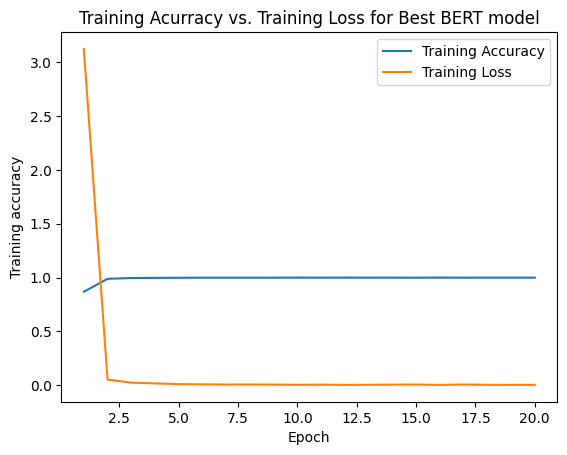

In [ ]:
# Plotting the training accuracy and loss per epoch
plt.figure()
epochs_list = list(range(1, epochs + 1))
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.title('Training Acurracy vs. Training Loss for Best BERT model')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.legend()
plt.show()

In [ ]:
# function for test
def test_results(m, test_data_loader):
    ret = evaluate(m, test_data_loader)
    true_results, predicted = ret['data']
    print(classification_report(true_results, predicted))
    return true_results, predicted

In [ ]:
# create the model with serialised parameters
best_model = BERT_Text_Classifier(bert, class_num=len(class_label))
best_model.to(device)
best_model.load_state_dict(best_model_state)

<All keys matched successfully>

In [ ]:
#saving model
PATH = "/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/best_model_final.pth"
torch.save(best_model.state_dict(), PATH)

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/amlh_nlp_dataset_2023/best_model_final_copy.pth"
torch.save(best_model.state_dict(), PATH)

##Model Performance##

In [ ]:
#printing model performance
true_results, predicted = test_results(best_model, test_data_loader)

100%|██████████| 3339/3339 [00:47<00:00, 70.49it/s]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1410
           1       0.99      0.99      0.99      1929

    accuracy                           0.99      3339
   macro avg       0.99      0.99      0.99      3339
weighted avg       0.99      0.99      0.99      3339



In [ ]:
#prting r^2 value
from sklearn.metrics import r2_score
r_squared = r2_score(true_results, predicted)
print("R^2 value:", r_squared)

R^2 value: 0.9607160583700076


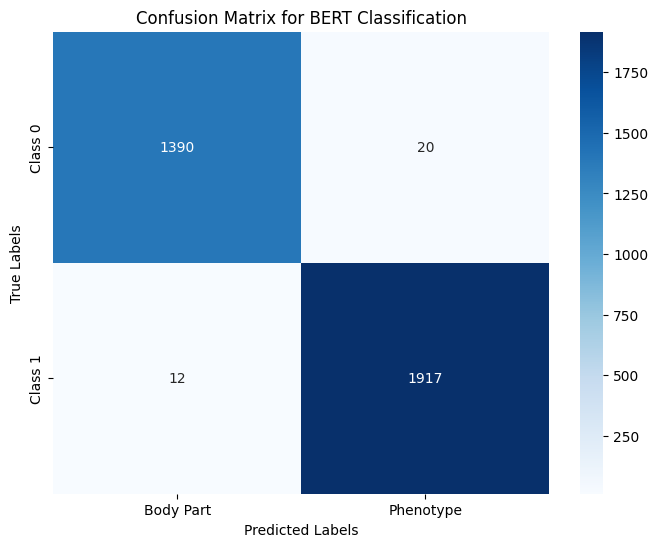

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_results, predicted)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Body Part', 'Phenotype'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for BERT Classification')
plt.show()

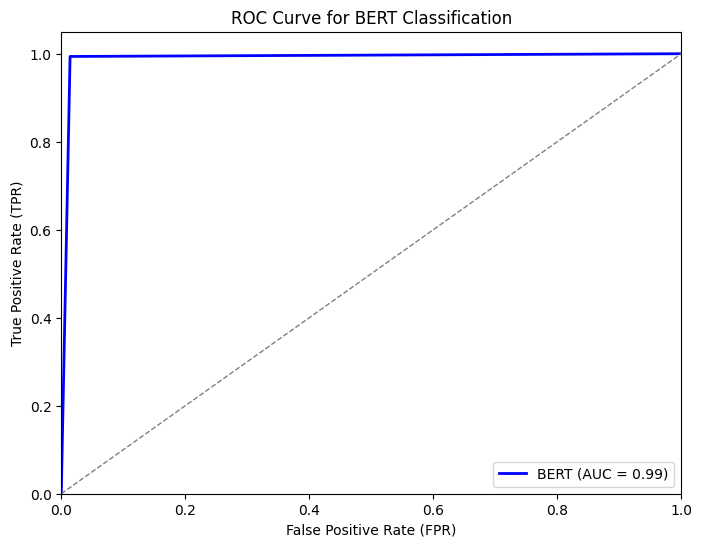

In [ ]:
# Compute the Area Under the ROC Curve (AUC)
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(true_results, predicted)
auc_score = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'BERT (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for BERT Classification')
plt.legend(loc='lower right')
plt.show()